In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_games = pd.read_csv("games.csv")
df_players = pd.read_csv("players.csv")
df_stats = pd.read_csv("stats.csv")

In [3]:
def find_winner(x):
    if x.homeTeamScore > x.awayTeamScore:
        return x.homeTeam
    elif x.homeTeamScore < x.awayTeamScore:
        return x.awayTeam
    return 'NA'

# create a winning team column 
df_games['winningTeam'] = df_games.apply(lambda x: find_winner(x),axis=1)

# create a losing team columns
df_games['losingTeam'] = df_games.apply(lambda x: x.awayTeam if x.homeTeam==x.winningTeam else x.homeTeam ,axis=1)

# create a year_round_id column
df_games['yearRoundId'] = df_games.apply(lambda x: x.gameId[:-2],axis=1)

# create margin column
df_games['margin'] = df_games.apply(lambda x: abs(x.homeTeamScore - x.awayTeamScore),axis=1)

# convert date to a date object so we can sort
df_games['date'] = pd.to_datetime(df_games['date'])

# earliest games are now first
df_games = df_games.sort_values(by=['date'],ascending=True)

In [4]:
teams = df_games['homeTeam'].unique()
teams.sort()
teams = teams.tolist()
teams.append('NA')

In [5]:
def update_elo(winner_elo, loser_elo):
    """
    update the ELO ratings
    """
    expected_win = expected_result(winner_elo, loser_elo)
    #expected_win_margin = expected_margin(winner_elo, loser_elo)
    change_in_elo = k_factor * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

def expected_margin(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = (elo_a - elo_b)/sigma
    print(expect_a)
    return expect_a

def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean/3
    return elos

In [6]:
mean_elo = 1500.
elo_width = 400.
n_samples = 8000 #used for predicting
std_margin = df_games['margin'].std()
k_factor = 32 

df_games['h_elo_before_game'] = 0
df_games['h_elo_after_game'] = 0
df_games['a_elo_before_game'] = 0
df_games['a_elo_after_game'] = 0

In [7]:
elo_per_season = {}


In [8]:
# we add 1 for the NA team that happens when teams draw
num_teams = len(teams)
current_elos = np.ones(shape=(num_teams)) * mean_elo

# add df for ELOs for each team
df_team_elos = pd.DataFrame(index=df_games['yearRoundId'].unique(), columns=range(num_teams))
df_team_elos.iloc[0, :] = current_elos

# where the magic happens
current_season = df_games.at[0, 'year']
current_round = df_games.at[0, 'round']

In [9]:
for row in df_games.itertuples():
    if row.year != current_season:
        # Check if we are starting a new season. 
        # Regress all ratings towards the mean
        current_elos = update_end_of_season(current_elos)
        # Write the beginning of new season ratings to a dict for later lookups.
        elo_per_season[row.year] = current_elos.copy()
        current_season = row.year

    idx = row.Index
    h_id = teams.index(row.homeTeam)
    a_id = teams.index(row.awayTeam)
    # Get current elos
    h_elo_before = current_elos[h_id]
    a_elo_before = current_elos[a_id]
    # Update on game results
    if row.winningTeam == row.homeTeam:
        h_elo_after, a_elo_after = update_elo(h_elo_before, a_elo_before)
    else:
        a_elo_after, h_elo_after = update_elo(a_elo_before, h_elo_before)

    # Save updated elos
    df_games.at[idx, 'h_elo_before_game'] = h_elo_before
    df_games.at[idx, 'a_elo_before_game'] = a_elo_before
    df_games.at[idx, 'h_elo_after_game'] = h_elo_after
    df_games.at[idx, 'a_elo_after_game'] = a_elo_after
    current_elos[h_id] = h_elo_after
    current_elos[a_id] = a_elo_after

    # Save elos to team DataFrame
    round_id = row.yearRoundId
    df_team_elos.at[round_id, h_id] = h_elo_after
    df_team_elos.at[round_id, a_id] = a_elo_after

In [10]:
cols = df_games['homeTeam'].unique().tolist()
cols.sort()
cols.append("NA")
df_team_elos.columns = cols
df_team_elos

,Adelaide,Brisbane Lions,Carlton,Collingwood,Essendon,Fremantle,Geelong,Gold Coast,Greater Western Sydney,Hawthorn,Melbourne,North Melbourne,Port Adelaide,Richmond,St Kilda,Sydney,West Coast,Western Bulldogs,NA
2012R1,1516.0,1516.0,1516.0,1484.0,1516.0,1516.0,1484.0,1484.0,1484.0,1516.0,1484.0,1484.0,1516.0,1484.0,1484.0,1516.0,1516.0,1484.0,1500.0
2012R2,1530.530498,1500.0,1532.0,1500.0,1532.0,1500.0,1501.469502,1468.0,1468.0,1498.530498,1469.469502,1500.0,1500.0,1468.0,1500.0,1532.0,1530.530498,1469.469502,NaN
2012R3,1513.060997,1484.0,1546.530498,1485.469502,1545.085581,1516.0,1485.401829,1454.914419,1454.848941,1516.0,1453.401829,1516.067673,1485.469502,1484.067673,1514.597626,1546.530498,1543.681557,1454.871875,NaN
2012R4,1526.405039,1498.66368,1530.463958,1501.469502,1561.152121,1531.935419,1501.340389,1440.250739,1441.504899,1501.272092,1437.469527,1501.466954,1469.469502,1468.129113,1498.662208,1561.131217,1558.409465,1470.804177,NaN
2012R5,1539.806282,1482.786944,1546.531721,1520.191269,1542.430354,1515.867656,1517.217124,1427.041035,1426.850991,1488.001752,1424.258772,1514.676658,1456.068259,1456.195562,1511.872962,1574.401558,1570.343015,1485.458085,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021QF,NaN,1603.288771,NaN,NaN,NaN,NaN,1622.75509,NaN,NaN,NaN,1627.940632,NaN,1678.373034,NaN,NaN,NaN,NaN,NaN,NaN
2021EF,NaN,NaN,NaN,NaN,1489.680909,NaN,NaN,NaN,1558.588102,NaN,NaN,NaN,NaN,NaN,NaN,1540.282579,NaN,1580.27463,NaN
2021SF,NaN,1586.230478,NaN,NaN,NaN,NaN,1635.833237,NaN,1545.509955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1597.332923,NaN
2021PF,NaN,NaN,NaN,NaN,NaN,NaN,1619.469831,NaN,NaN,NaN,1644.304037,NaN,1658.70724,NaN,NaN,NaN,NaN,1616.998717,NaN


In [11]:
print(df_team_elos.loc['2021R22'])


Adelaide                  1368.023329
Brisbane Lions            1609.085878
Carlton                   1425.144573
Collingwood               1421.075225
Essendon                  1489.873342
Fremantle                 1478.065781
Geelong                   1656.465205
Gold Coast                1382.738172
Greater Western Sydney      1530.6068
Hawthorn                  1448.463237
Melbourne                 1592.662341
North Melbourne           1338.384741
Port Adelaide              1650.78419
Richmond                   1510.05026
St Kilda                  1484.076599
Sydney                    1548.063274
West Coast                1486.442984
Western Bulldogs          1579.994066
NA                                NaN
Name: 2021R22, dtype: object


In [12]:
df_team_elos.fillna(method='ffill', inplace=True)


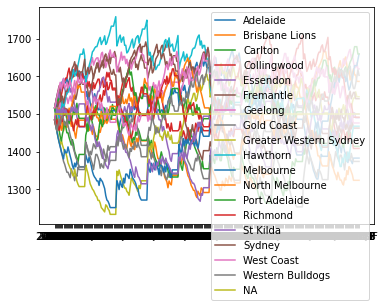

In [13]:
plt.plot(df_team_elos)
plt.legend(cols)

-0.7602601994963146


/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


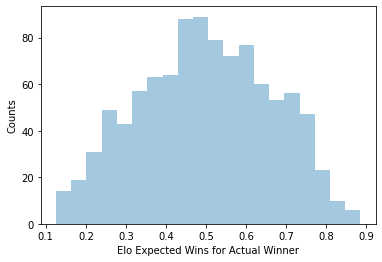

In [14]:
n_samples = 1000
samples = df_games[df_games.year > 2015].sample(n_samples)
loss=0
expected_list = []
for row in samples.itertuples():
    h_elo = row.h_elo_before_game
    a_elo = row.a_elo_before_game
    h_expected = expected_result(h_elo, a_elo)
    expected_list.append(h_expected)
    loss += np.log(h_expected)
print(loss/n_samples)

sns.distplot(expected_list, kde=False, bins=20)
plt.xlabel('Elo Expected Wins for Actual Winner')
plt.ylabel('Counts')
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [37]:
df_games_model = df_games.drop(['attendance','round','h_elo_after_game','a_elo_after_game','margin','losingTeam','gameId','date','yearRoundId','homeTeamScore','awayTeamScore'],axis=1)

In [48]:
df_games_model.fillna(method='ffill', inplace=True)

In [49]:
df_train = df_games_model.where(df_games_model['year']!=2021).dropna()
x_train = df_train.loc[:, df_train.columns != 'winningTeam']
y_train = df_train.loc[:,'winningTeam']
y_train

1817    16.0
1818     2.0
1819     9.0
1823     4.0
1820     1.0
        ... 
364     14.0
365      6.0
366     14.0
367      6.0
368     14.0
Name: winningTeam, Length: 1817, dtype: float64

In [50]:
df_test = df_games_model.where(df_games_model['year']==2021).dropna()
x_test = df_test.loc[:, df_test.columns != 'winningTeam']
y_test = df_test.loc[:,'winningTeam']
y_test

0      14.0
1      18.0
2      10.0
3       0.0
4       9.0
       ... 
202     6.0
203    18.0
204    10.0
205    18.0
206    10.0
Name: winningTeam, Length: 207, dtype: float64

In [51]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in df_games_model.columns:
        if df_games_model[column_name].dtype == object:
            df_games_model[column_name] = le.fit_transform(df_games_model[column_name])
        else:
            pass

In [52]:
df_test = df_games_model.loc[:, df_games_model.columns == 'winningTeam']
df_train = df_games_model.loc[:, df_games_model.columns != 'winningTeam']

In [53]:
train_features, test_features, train_labels, test_labels = train_test_split(df_train, df_test, test_size = 0.25, random_state = 42)

In [54]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1518, 8)
Training Labels Shape: (1518, 1)
Testing Features Shape: (506, 8)
Testing Labels Shape: (506, 1)


In [61]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

/var/folders/y5/lyr7l8ds5mbb60cw701w_7vh0000gn/T/ipykernel_60227/3689357811.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_features, train_labels);


In [91]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features).reshape(506,1)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: winningTeam    2.69
dtype: float64 degrees.


/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [92]:
res = test_labels - predictions
sum(res['winningTeam'] == 0)/len(res)

0.5731225296442688